<a href="https://colab.research.google.com/github/Moly-malibu/AgroEdit/blob/master/Permutation_DS_predict_chicago_food_inspections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍕

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap
    !pip install eli5

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Confusion Matrix
- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [3]:
from sklearn.model_selection import train_test_split
# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['Fail'], random_state=42)

train.shape, val.shape, test.shape

((41532, 17), (10384, 17), (17306, 17))

In [4]:
#With normalize set to True, returns the relative frequency by dividing all values by the sum of values.
train['Fail'].value_counts(normalize=True)

0    0.74138
1    0.25862
Name: Fail, dtype: float64

In [5]:
train.describe()

,Inspection ID,License #,Zip,Latitude,Longitude,Fail
count,4.153200e+04,4.152800e+04,41510.000000,41385.000000,41385.000000,41532.000000
mean,1.327653e+06,1.548519e+06,60628.746591,41.879559,-87.676578,0.258620
std,6.211008e+05,9.031007e+05,22.979353,0.081205,0.059327,0.437882
min,4.425100e+04,0.000000e+00,60007.000000,41.646371,-87.914428,0.000000
25%,6.793452e+05,1.139382e+06,60614.000000,41.830269,-87.707725,0.000000
50%,1.418942e+06,1.959154e+06,60625.000000,41.890196,-87.666745,0.000000
75%,1.946773e+06,2.215531e+06,60643.000000,41.939168,-87.634537,1.000000
max,2.279709e+06,8.700606e+06,60827.000000,42.021064,-87.525094,1.000000


In [0]:
import numpy as np

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['Latitude'] = X['Latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['Longitude', 'Latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
    
    # return the wrangled dataframe
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
#Specific importance features and target
features = ['Inspection ID', 'Facility Type', 'Risk', 'Inspection Type', 'Violations'] 
target = 'Fail' 

In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [9]:
# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)

['Inspection ID', 'License #', 'Zip', 'Latitude', 'Longitude', 'Risk', 'City', 'State', 'Inspection Type']


In [10]:
train.describe(exclude='number')

,DBA Name,AKA Name,Facility Type,Risk,Address,City,State,Inspection Date,Inspection Type,Violations,Location
count,41532,41028,41357,41523,41532,41488,41525,41532,41531,33789,41385
unique,15705,15086,292,3,13209,35,1,2251,46,33727,12744
top,SUBWAY,SUBWAY,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,2017-03-23T00:00:00,Canvass,45. FOOD HANDLER REQUIREMENTS MET - Comments: ...,"{'longitude': '-87.91442843927047', 'latitude'..."
freq,527,640,27449,30143,591,41319,41525,45,19356,3,591


#Encode

In [11]:
# Arrange data into X features matrix and y target vector: Encoder $ Fit (Classifier)
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    RandomForestClassifier(n_jobs=-1, random_state=0)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.7251540832049307


## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [12]:
#Predictions Probabilities used XGBClassifier  ROC AUC test score >= 0.677
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.677158	validation_1-auc:0.604114
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.677176	validation_1-auc:0.604114
[2]	validation_0-auc:0.685501	validation_1-auc:0.615561
[3]	validation_0-auc:0.68788	validation_1-auc:0.605519
[4]	validation_0-auc:0.692706	validation_1-auc:0.606741
[5]	validation_0-auc:0.696301	validation_1-auc:0.640649
[6]	validation_0-auc:0.696404	validation_1-auc:0.640595
[7]	validation_0-auc:0.694312	validation_1-auc:0.631149
[8]	validation_0-auc:0.692859	validation_1-auc:0.630895
[9]	validation_0-auc:0.694476	validation_1-auc:0.629437
[10]	validation_0-auc:0.695376	validation_1-auc:0.629375
[11]	validation_0-auc:0.696111	validation_1-auc:0.629685
[12]	validation_0-auc:0.697136	validation_1-auc:0.629641
[13]	validation_0-auc:0.696251	validation_1-auc:0.629683
[14]	validation_0-auc:0.69868	validation_1-auc:0.628807


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [13]:
#ROC AUC test score >= 0.66 
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
class_index = 1
y_pred_proba = model.predict_proba(X_test_processed)[:, class_index]
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba)) 

Test ROC AUC for class 1:
0.6640580577154926


## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

#Visutalization SHAP Feature Importance

In [16]:
row = X_test.iloc[[3094]]
row

,Inspection ID,Facility Type,Risk,Inspection Type,Violations
3094,177025,Restaurant,Risk 1 (High),License,31. CLEAN MULTI-USE UTENSILS AND SINGLE SERVIC...


In [17]:
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # For classification, this shows predicted probabilities
)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


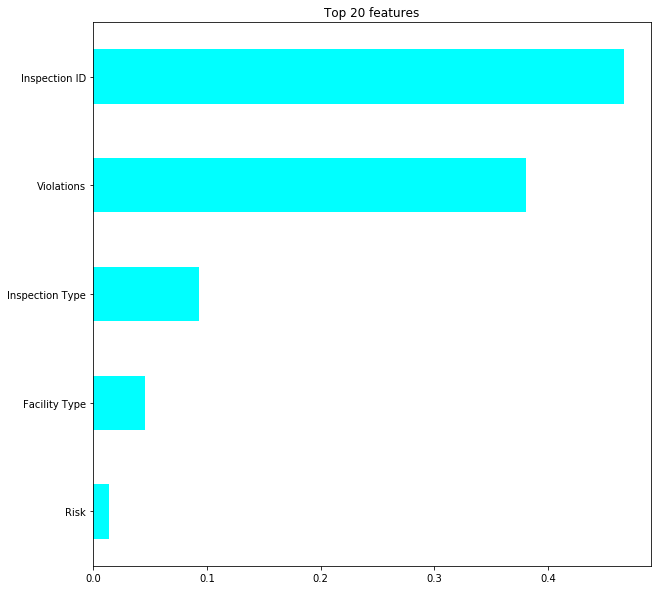

In [18]:
#Graphic features Importance
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='Cyan');

#Part 3: Visualization
Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:


#Partial Dependence Plot, 1 feature isolation


In [19]:
#Partial Dependence Plot, 1 feature isolation: Step 1
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Series.base is deprecated and will be removed in a future version
Series.base is deprecated and will be removed in a future version


Gradient Boosting R^2 0.049059435470748536


In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [0]:
#step 2
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [0]:
#step 3
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Inspection ID'

isolated = pdp_isolate(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


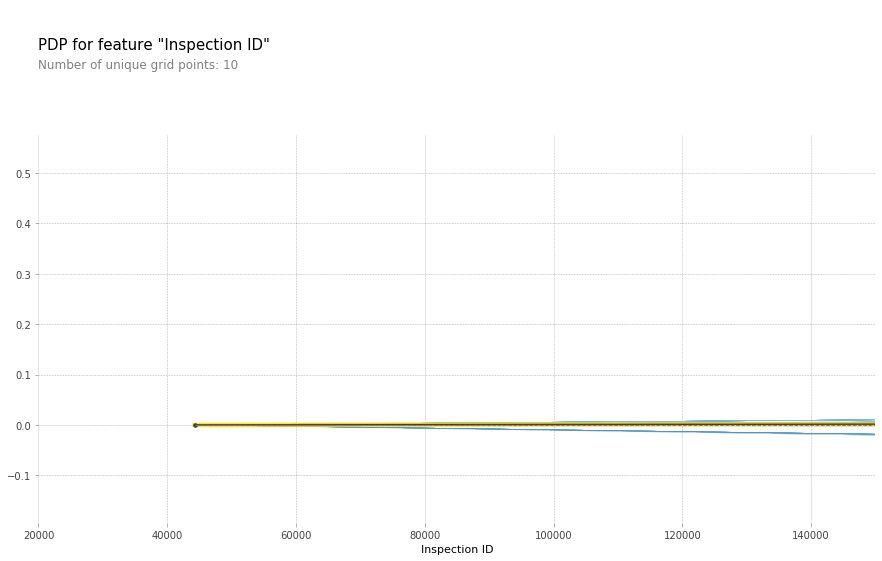

In [23]:
# ICE: Individual Conditional Expectation: step 4
pdp_plot(isolated, feature_name=feature, plot_lines=True, 
         frac_to_plot=0.01)

plt.xlim(20000,150000);

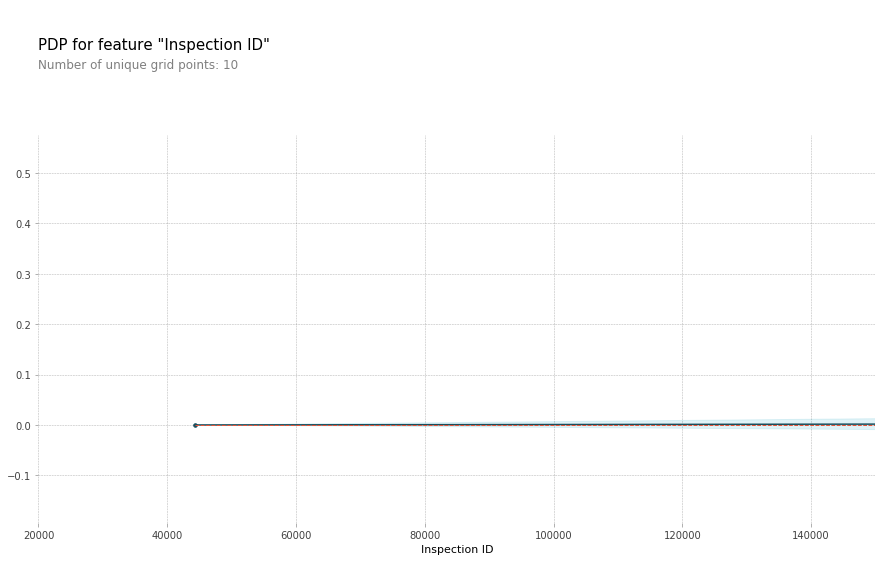

In [24]:
pdp_plot(isolated, feature_name=feature)
plt.xlim((20000,150000));

In [25]:
train.columns.values

array(['Inspection ID', 'DBA Name', 'AKA Name', 'License #',
       'Facility Type', 'Risk', 'Address', 'City', 'State', 'Zip',
       'Inspection Date', 'Inspection Type', 'Violations', 'Latitude',
       'Longitude', 'Location', 'Fail'], dtype=object)

In [26]:
#Graphic Latitud and Longitude
import plotly.express as px
px.scatter(train, x='Longitude', y='Latitude', color='Fail', opacity=.1)

In [27]:
# plotly using mapbox
fig = px.scatter_mapbox(train, lat='Latitude', lon='Longitude', color='Fail',opacity=0.2)
fig.update_layout(mapbox_style='stamen-terrain')
fig.show()